# 오디오 분류(Audio Classification)

* 가상 악기를 활용해 악기별 음색 데이터셋을 활용해 오디오 분류

1. 기존 데이터에서 분류에 사용되는 방법을 사용해 분류
2. 오디오 데이터에 특화된 분류

* 출처: https://bab2min.tistory.com/642

### 데이터 준비 및 전처리

In [5]:
import numpy as np
import itertools
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')

* 데이터를 저장할 리스트와 파일을 불러올 경로를 지정

* http://suanlab.com/datasets/GeneralMidi.wav



In [6]:
!wget http://suanlab.com/datasets/GeneralMidi.wav

--2024-06-20 22:22:00--  http://suanlab.com/datasets/GeneralMidi.wav
Resolving suanlab.com (suanlab.com)... 52.219.202.76, 52.219.56.144, 52.219.146.88, ...
Connecting to suanlab.com (suanlab.com)|52.219.202.76|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3409459756 (3.2G) [audio/wav]
Saving to: ‘GeneralMidi.wav’

GeneralMidi.wav     100%[===================>]   3.17G  25.8MB/s    in 2m 7s   

2024-06-20 22:24:07 (25.6 MB/s) - ‘GeneralMidi.wav’ saved [3409459756/3409459756]



In [7]:
midi_file ="./GeneralMidi.wav"

* wmv 파일에는 128개 악기와 46개 타악기의 음을 50개씩 2초 간격으로 존재
* 해당 예제에서는 일부 악기만 선택해서 사용

In [8]:
instruments = [0,10,20,30,40,50,60,70,80,90]
num_notes = 50
sec = 2.0

audio = []
inst = []

for inst_idx,note in itertools.product(range(len(instruments)),range(num_notes)):
  instrument = instruments[inst_idx]
  offset = ( instrument * num_notes * sec ) + (note * sec)
  print(f'instrument : {instrument}, note : {note}, offset : {offset}')
  y, sr = librosa.load(midi_file, sr=None, offset=offset, duration=sec)
  audio.append(y)
  inst.append(inst_idx)


instrument : 0, note : 0, offset : 0.0
instrument : 0, note : 1, offset : 2.0
instrument : 0, note : 2, offset : 4.0
instrument : 0, note : 3, offset : 6.0
instrument : 0, note : 4, offset : 8.0
instrument : 0, note : 5, offset : 10.0
instrument : 0, note : 6, offset : 12.0
instrument : 0, note : 7, offset : 14.0
instrument : 0, note : 8, offset : 16.0
instrument : 0, note : 9, offset : 18.0
instrument : 0, note : 10, offset : 20.0
instrument : 0, note : 11, offset : 22.0
instrument : 0, note : 12, offset : 24.0
instrument : 0, note : 13, offset : 26.0
instrument : 0, note : 14, offset : 28.0
instrument : 0, note : 15, offset : 30.0
instrument : 0, note : 16, offset : 32.0
instrument : 0, note : 17, offset : 34.0
instrument : 0, note : 18, offset : 36.0
instrument : 0, note : 19, offset : 38.0
instrument : 0, note : 20, offset : 40.0
instrument : 0, note : 21, offset : 42.0
instrument : 0, note : 22, offset : 44.0
instrument : 0, note : 23, offset : 46.0
instrument : 0, note : 24, offs

In [9]:
audio_np = np.array(audio, np.float32)
inst_np = np.array(inst, np.int16)

print(audio_np.shape,inst_np.shape)

(500, 88200) (500,)


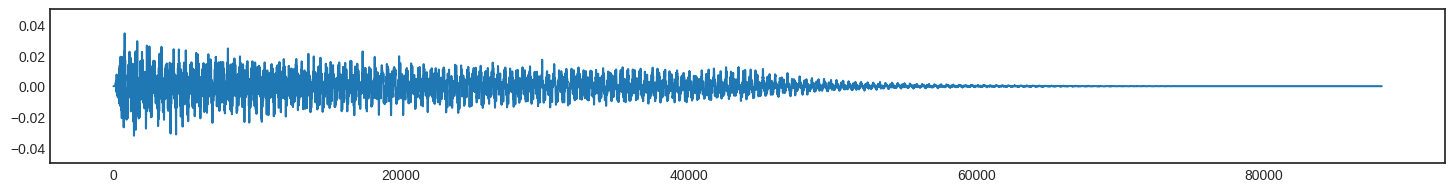

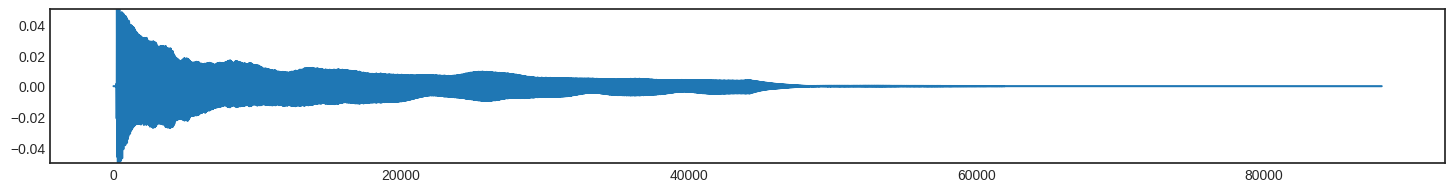

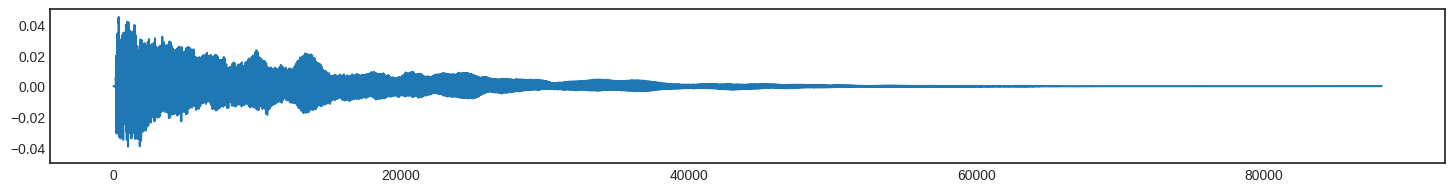

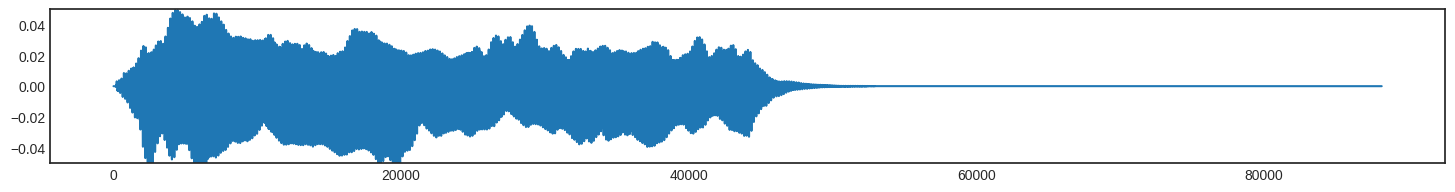

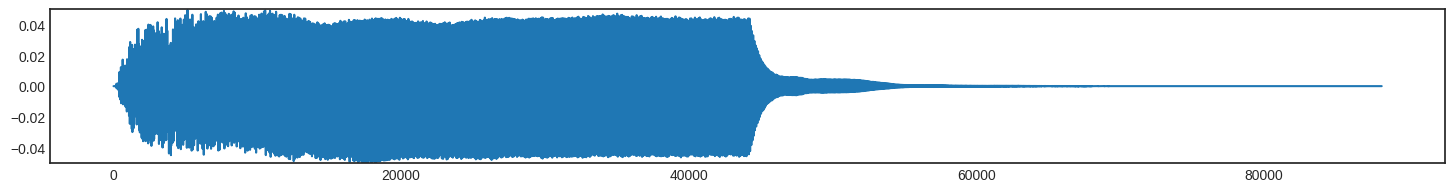

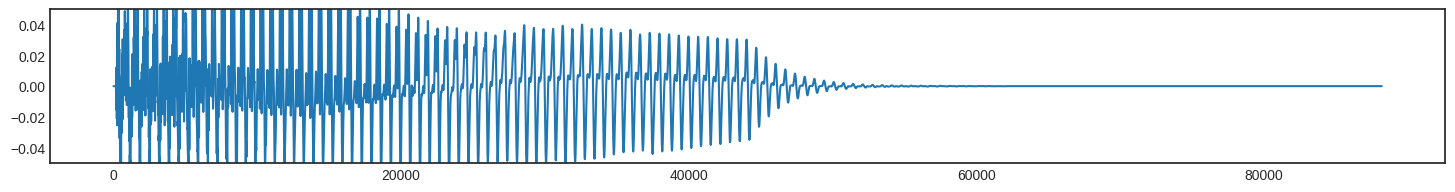

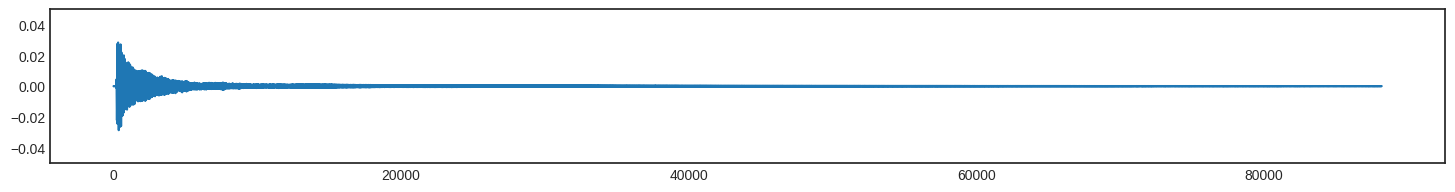

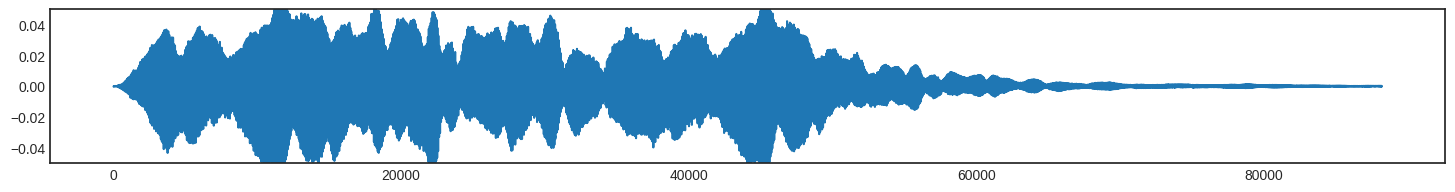

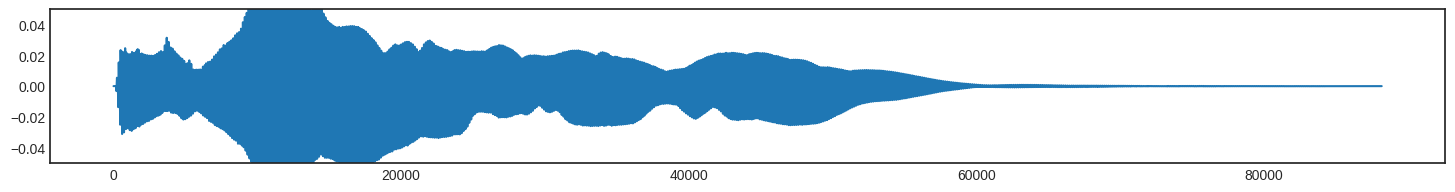

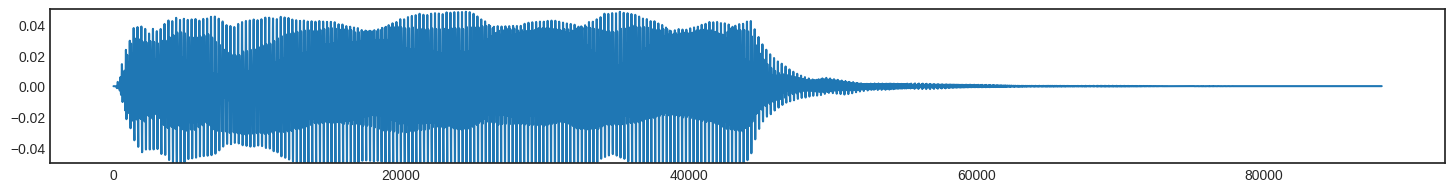

In [10]:
for idx in range(0, len(audio_np), num_notes):
  plt.figure(figsize=(18, 2))
  plt.plot(audio_np[idx])
  plt.ylim(-0.05,0.05)
  plt.show()

In [11]:
print(inst_np[0])
ipd.Audio(audio_np[0], rate=sr)

0


In [12]:
print(inst_np[50])
ipd.Audio(audio_np[50], rate=sr)

1


In [13]:
print(inst_np[100])
ipd.Audio(audio_np[100], rate=sr)

2


In [14]:
print(inst_np[150])
ipd.Audio(audio_np[150], rate=sr)

3


In [15]:
print(inst_np[200])
ipd.Audio(audio_np[200], rate=sr)

4


In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(audio_np)

MinMaxScaler()

## 머신러닝을 이용한 오디오 분류

* 학습 데이터와 실험 데이터를 분리

In [17]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(audio_np, inst_np, test_size=0.2)

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(400, 88200) (400,)
(100, 88200) (100,)


### Logistic Regression

* Logistic Regression은 특성상 다중 분류에는 적합하지 않음

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

LR = LogisticRegression()
LR.fit(train_x, train_y)
pred = LR.predict(test_x)
acc = accuracy_score(pred, test_y)
print(f"정답률 : {acc * 100}%")

정답률 : 4.0%


### Support Vector Machine

In [19]:
from sklearn import svm
SVM = svm.SVC(kernel='linear')
SVM.fit(train_x, train_y)
pred = SVM.predict(test_x)
acc = accuracy_score(pred, test_y)
print(f"정답률 : {acc * 100}%")

정답률 : 7.000000000000001%


### Decision Tree

In [20]:
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier()
DT.fit(train_x, train_y)
pred = DT.predict(test_x)
acc = accuracy_score(pred, test_y)
print(f"정답률 : {acc * 100}%")

정답률 : 27.0%


## Constant-Q를 이용한 머신러닝 오디오 분류

### 데이터 준비

* wav는 매 순간의 음압을 측정하여 그 수치를 저장한 형태이기 때문에 그 자체로 음악을 분석하기에 적합하지 않음 (음의 높이와 세기를 듣는것이지 순간의 음압을 듣는게 아니기 때문)
* 푸리에 변환과 같은 변환 기법을 이용하여 시간 축의 데이터를 주파수 축의 데이터로 바꿔줘야할 필요가 있음
* 푸리에 변환 대신 푸리에 변환과 유사한 Constant-Q 변환을 사용
* Constant-Q 변환은 주파수 축이 로그 단위로 변환되고, 각 주파수에 따라 해상도가 다양하게 처리되기 때문에(저주파는 저해상도, 고주파는 고해상도) 음악을 처리하는 데에 푸리에 변환보다 유리

*   주파수 대역을 저장할 리스트 `audio_cqt` 선언
*   constant-Q 변환할 때는 변환할 오디오 데이터와 sampling rate가 필요
*   해당 데이터에서는 sampling rate가 모두 동일하므로 따로 처리가 필요하지 않음
*   여기서는 Constant-Q 변환을 사용해 오디오 데이터를 주파수 대역으로 변환




*   변환에는 앞서 준비한 데이터를 가져와 사용하며, Constant-Q 변환에는 `librosa.cqt` 함수를 사용
*   여기서 `n_bins`는 옥타브 단계 및 개수를, `bins_per_octave`는 한 옥타브가 가지는 단계를 의미
*   라벨에 대해선 원 핫 인코딩을 적용



In [21]:
audio_cqt = []

for y in audio:
  ret = librosa.cqt(y, sr=sr, hop_length=1024, n_bins=24*7, bins_per_octave=24)
  ret = np.abs(ret)
  audio_cqt.append(ret)

* 앞서 생성한 주파수 대역을 spectrogram으로 시각화
* 악기 간 spectrogram을 비교해보면 차이가 존재함을 알 수 있음

<ipython-input-22-c47e7e99d29d>:3: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(amp_db, sr=sr, x_axis='time', y_axis='cqt_note')


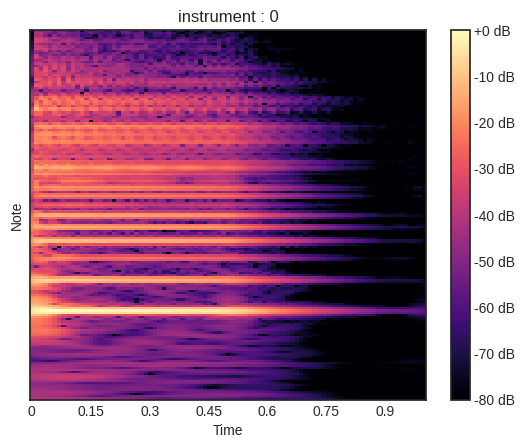

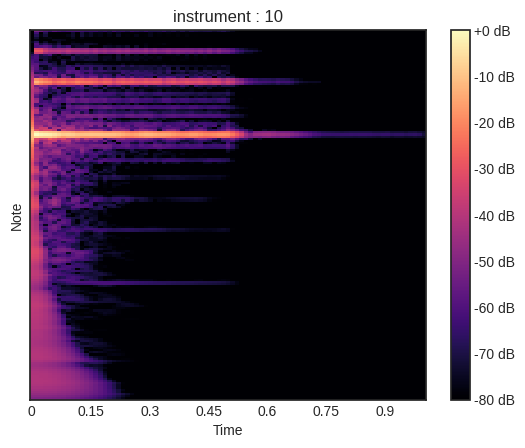

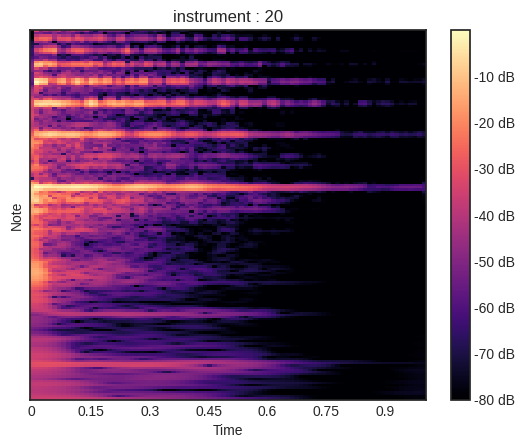

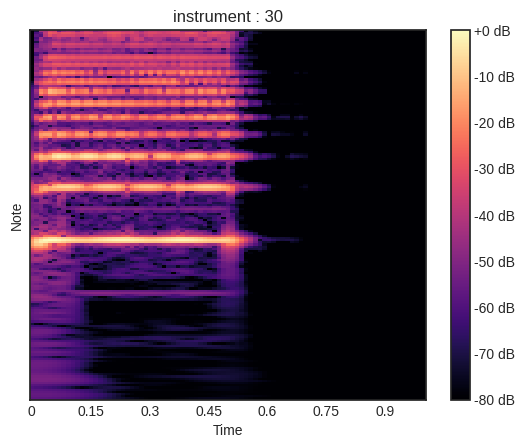

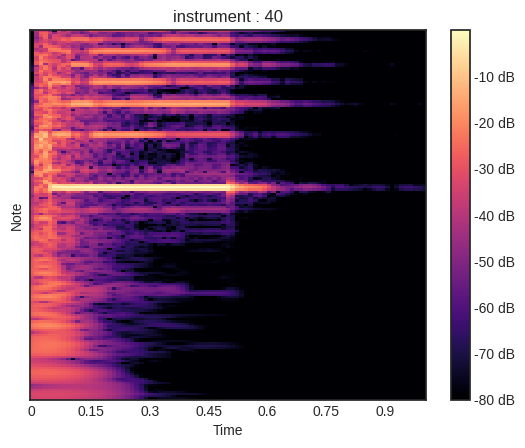

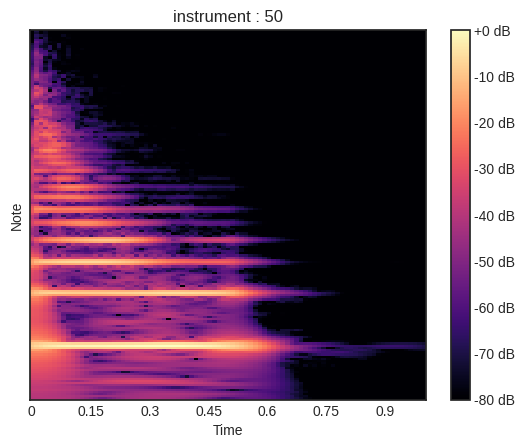

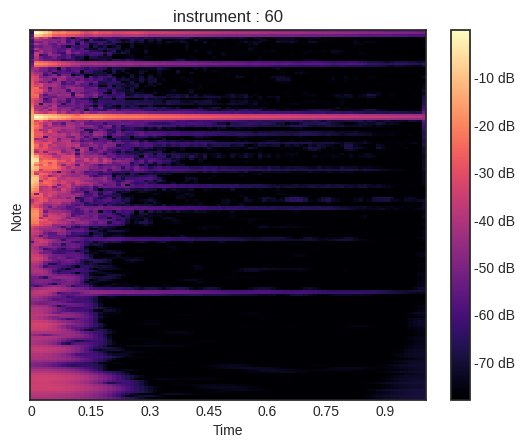

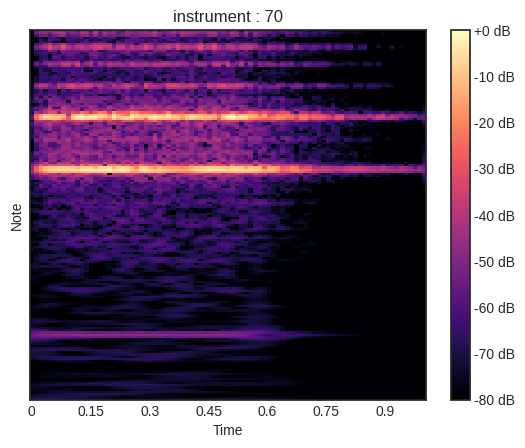

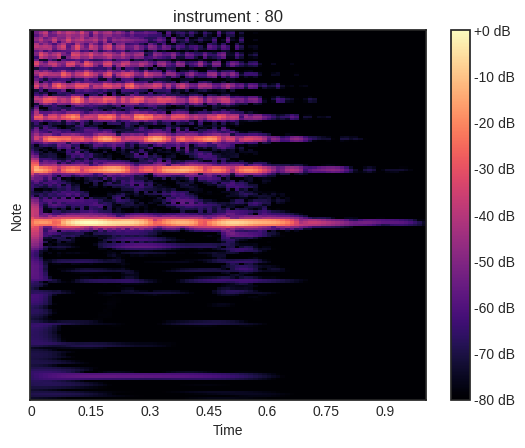

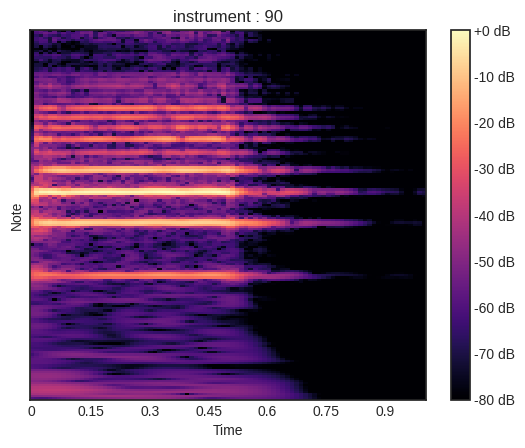

In [22]:
for i in range(0, len(instruments) * num_notes, num_notes):
  amp_db = librosa.amplitude_to_db(np.abs(audio_cqt[i]), ref=np.max)
  librosa.display.specshow(amp_db, sr=sr, x_axis='time', y_axis='cqt_note')
  plt.colorbar(format='%+2.0f dB')
  plt.title(f'instrument : {instruments[i // num_notes]}')
  plt.show()

* 훈련 데이터와 실험 데이터를 분리

In [23]:
cqt_np = np.array(audio_cqt, np.float32)
inst_np = np.array(inst, np.int16)

print(cqt_np.shape,inst_np.shape)

(500, 168, 87) (500,)




*   분류기에서 사용하기 위해 3차원 벡터를 2차원 벡터로 변환



In [24]:
cqt_np = cqt_np.reshape((500,168*87))
print(cqt_np.shape)

(500, 14616)




*   읽어온 데이터는 음량이나 범위가 다를 수 있음
*   min-max scaling을 통해 데이터의 범위를 조정함



In [25]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(cqt_np)

MinMaxScaler()

* 학습 데이터와 실험 데이터를 분리

In [26]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(cqt_np, inst_np, test_size=0.2)

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(400, 14616) (400,)
(100, 14616) (100,)


### Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

LR = LogisticRegression()
LR.fit(train_x, train_y)
pred = LR.predict(test_x)
acc = accuracy_score(pred, test_y)
print(f"정답률 : {acc * 100}%")

정답률 : 34.0%


### Support Vector Machine

In [28]:
from sklearn import svm
SVM = svm.SVC(kernel='linear')
SVM.fit(train_x, train_y)
pred = SVM.predict(test_x)
acc = accuracy_score(pred, test_y)
print(f"정답률 : {acc * 100}%")

정답률 : 38.0%


### Decision Tree

In [29]:
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier()
DT.fit(train_x, train_y)
pred = DT.predict(test_x)
acc = accuracy_score(pred, test_y)
print(f"정답률 : {acc * 100}%")

정답률 : 59.0%


In [30]:
LR = None
SVM = None
DT = None

## Constant-Q 특징을 이용한 딥러닝 오디오 분류

* 오디오 데이터를 spectrogram으로 가공하면 파장과 세기를 가진 이미지(2차원 배열)가 생성
* 이 spectrogram을 CNN 이미지 분류를 통해 각 악기 소리를 분류

### DNN 모델 구성

In [31]:
from keras.utils import to_categorical

cqt_np = np.array(audio_cqt, np.float32)
cqt_np = cqt_np.reshape((500,168 * 87))
cqt_array = np.expand_dims(cqt_np, -1)
inst_cat = to_categorical(inst_np)

train_x, test_x, train_y, test_y = train_test_split(cqt_array, inst_cat, test_size=0.2)

print(train_x.shape, test_x.shape)
print(train_y.shape, test_y.shape)

(400, 14616, 1) (100, 14616, 1)
(400, 10) (100, 10)


In [32]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense

def model_build():
  model = Sequential()
  input = Input(shape = (14616,), name='input')
  output = Dense(512, activation='relu', name='hidden1')(input)
  output = Dense(256, activation='relu', name='hidden2')(output)
  output = Dense(128, activation='relu', name='hidden3')(output)
  output = Dense(10, activation='softmax', name='output')(output)

  model = Model(inputs=[input], outputs=output)
  model.compile(loss='categorical_crossentropy', metrics=['acc'])
  return model

In [33]:
model = model_build()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 14616)]           0         
                                                                 
 hidden1 (Dense)             (None, 512)               7483904   
                                                                 
 hidden2 (Dense)             (None, 256)               131328    
                                                                 
 hidden3 (Dense)             (None, 128)               32896     
                                                                 
 output (Dense)              (None, 10)                1290      
                                                                 
Total params: 7649418 (29.18 MB)
Trainable params: 7649418 (29.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
history = model.fit(train_x, train_y, epochs=30, batch_size=128, validation_split=0.2)

Epoch 1/30
3/3 [==============================] - 3s 111ms/step - loss: 2.2714 - acc: 0.1000 - val_loss: 2.1824 - val_acc: 0.1625
Epoch 2/30
3/3 [==============================] - 0s 21ms/step - loss: 1.9931 - acc: 0.3688 - val_loss: 2.2354 - val_acc: 0.1625
Epoch 3/30
3/3 [==============================] - 0s 21ms/step - loss: 1.8366 - acc: 0.3781 - val_loss: 2.0539 - val_acc: 0.2500
Epoch 4/30
3/3 [==============================] - 0s 23ms/step - loss: 1.4668 - acc: 0.5531 - val_loss: 2.0637 - val_acc: 0.2625
Epoch 5/30
3/3 [==============================] - 0s 26ms/step - loss: 1.2723 - acc: 0.5938 - val_loss: 2.1559 - val_acc: 0.2625
Epoch 6/30
3/3 [==============================] - 0s 24ms/step - loss: 1.0811 - acc: 0.6656 - val_loss: 2.1415 - val_acc: 0.3000
Epoch 7/30
3/3 [==============================] - 0s 25ms/step - loss: 0.9801 - acc: 0.7156 - val_loss: 2.0629 - val_acc: 0.3500
Epoch 8/30
3/3 [==============================] - 0s 23ms/step - loss: 0.7952 - acc: 0.8125 - va

In [35]:
def plot_history(history_dict):
  loss = history_dict['loss']

  val_loss = history_dict['val_loss']

  epochs = range(1, len(loss) + 1 )
  fig = plt.figure(figsize=(14,5))

  ax1 = fig.add_subplot(1,2,1)
  ax1.plot(epochs, loss, 'b--', label='train_loss')
  ax1.plot(epochs, val_loss, 'r:', label='val_loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.grid()
  ax1.legend()


  acc = history_dict['acc']
  val_acc = history_dict['val_acc']

  ax2 = fig.add_subplot(1,2,2)
  ax2.plot(epochs, acc, 'b--', label='train_accuracy')
  ax2.plot(epochs, val_acc, 'r:', label='val_accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Loss')
  ax2.grid()
  ax2.legend()

  plt.show()

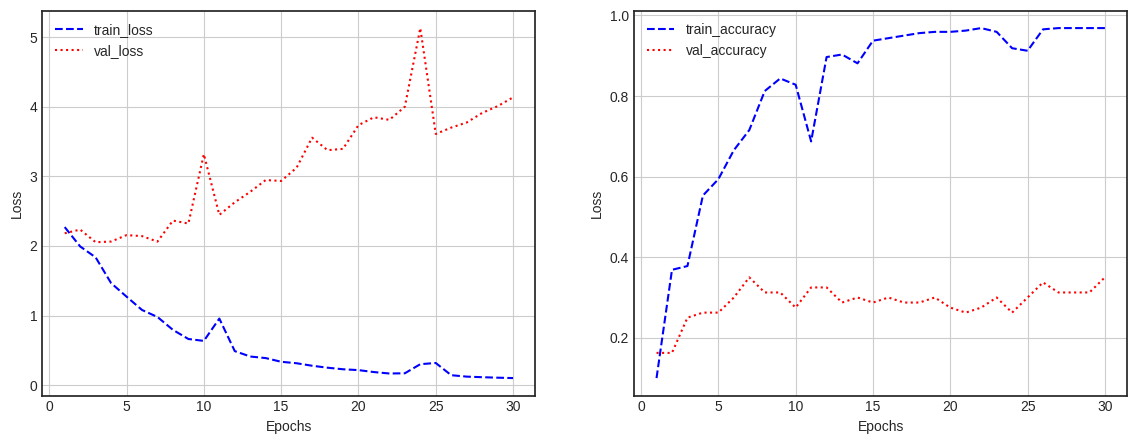

In [36]:
plot_history(history.history)

In [37]:
model.evaluate(test_x,test_y)

4/4 [==============================] - 0s 12ms/step - loss: 4.2081 - acc: 0.2900


[4.208129405975342, 0.28999999165534973]

### CNN 모델 구성



*   spectrogram을 분류할 CNN 모델 구성
*   모델의 구성은 여타 이미지 분류 모델과 다르지 않음
*   spectrogram은 1차원 이미지로 간주


In [38]:
from keras.utils import to_categorical

cqt_np = np.array(audio_cqt, np.float32)
cqt_array = np.expand_dims(cqt_np, -1)
inst_cat = to_categorical(inst_np)

train_x, test_x, train_y, test_y = train_test_split(cqt_array, inst_cat, test_size=0.2)

print(train_x.shape, test_x.shape)
print(train_y.shape, test_y.shape)

(400, 168, 87, 1) (100, 168, 87, 1)
(400, 10) (100, 10)


In [40]:
from keras.layers import Conv2D, MaxPool2D, Flatten, Input, Dense
from keras.models import Sequential, Model
def model_build():
  model = Sequential()

  input = Input(shape = (168,87,1))

  output = Conv2D(128, 3, strides=1, padding='same', activation='relu')(input)
  output = MaxPool2D(pool_size=(2,2), strides=2, padding='same' )(output)

  output = Conv2D(256, 3, strides=1, padding='same', activation='relu')(output)
  output = MaxPool2D(pool_size=(2,2), strides=2, padding='same' )(output)

  output = Conv2D(512, 3, strides=1, padding='same', activation='relu')(output)
  output = MaxPool2D(pool_size=(2,2), strides=2, padding='same' )(output)

  output = Flatten()(output)
  output = Dense(512, activation='relu')(output)
  output = Dense(256, activation='relu')(output)
  output = Dense(128, activation='relu')(output)
  output = Dense(10, activation='softmax')(output)

  model = Model(inputs=[input], outputs=output)

  model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['acc']
  )
  return model


In [41]:
model = model_build()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 168, 87, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 168, 87, 128)      1280      
                                                                 
 max_pooling2d (MaxPooling2  (None, 84, 44, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 84, 44, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 42, 22, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 42, 22, 512)       1180

In [42]:
history = model.fit(train_x, train_y, epochs=20, batch_size=128, validation_split=0.2)

Epoch 1/20
3/3 [==============================] - 29s 5s/step - loss: 2.2452 - acc: 0.1625 - val_loss: 2.0354 - val_acc: 0.3000
Epoch 2/20
3/3 [==============================] - 1s 260ms/step - loss: 1.7917 - acc: 0.3313 - val_loss: 1.7168 - val_acc: 0.3375
Epoch 3/20
3/3 [==============================] - 1s 264ms/step - loss: 1.4015 - acc: 0.4594 - val_loss: 1.4282 - val_acc: 0.4125
Epoch 4/20
3/3 [==============================] - 1s 258ms/step - loss: 1.1108 - acc: 0.6000 - val_loss: 1.4675 - val_acc: 0.4250
Epoch 5/20
3/3 [==============================] - 1s 248ms/step - loss: 0.9174 - acc: 0.6844 - val_loss: 1.2451 - val_acc: 0.5375
Epoch 6/20
3/3 [==============================] - 1s 248ms/step - loss: 0.6598 - acc: 0.7969 - val_loss: 0.8453 - val_acc: 0.6500
Epoch 7/20
3/3 [==============================] - 1s 251ms/step - loss: 0.4494 - acc: 0.8406 - val_loss: 0.6866 - val_acc: 0.7375
Epoch 8/20
3/3 [==============================] - 1s 251ms/step - loss: 0.2884 - acc: 0.8906

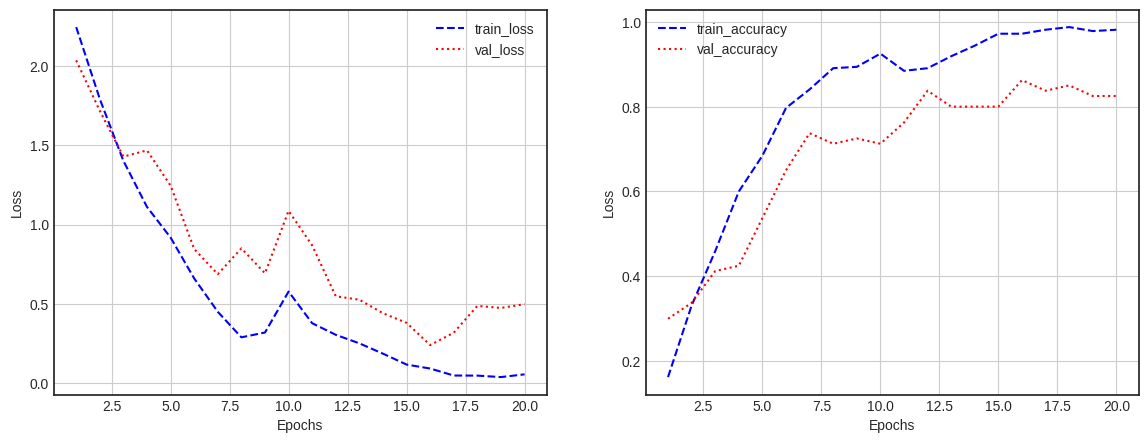

In [43]:
plot_history(history.history)



*   훈련한 모델에 대한 정확도 평가
*   앞선 일반 분류 방법보다 정확도가 많이 오른 것을 확인할 수 있음



In [44]:
model.evaluate(test_x,test_y)

4/4 [==============================] - 2s 111ms/step - loss: 0.6401 - acc: 0.8500


[0.6401364207267761, 0.8500000238418579]

## MFCC를 이용한 머신러닝 오디오 분류

### 데이터 준비

* 데이터를 불러오고 MFCC(Mel-frequency cepstral coefficients)를 사용해 melspectrogram으로 변환

In [45]:
audio_mfcc = []
for y in audio:
  ret = librosa.feature.mfcc(y=y, sr=sr)
  audio_mfcc.append(ret)

<ipython-input-46-2433a67c89ee>:6: UserWarning: Glyph 9839 (\N{MUSIC SHARP SIGN}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9839 (\N{MUSIC SHARP SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


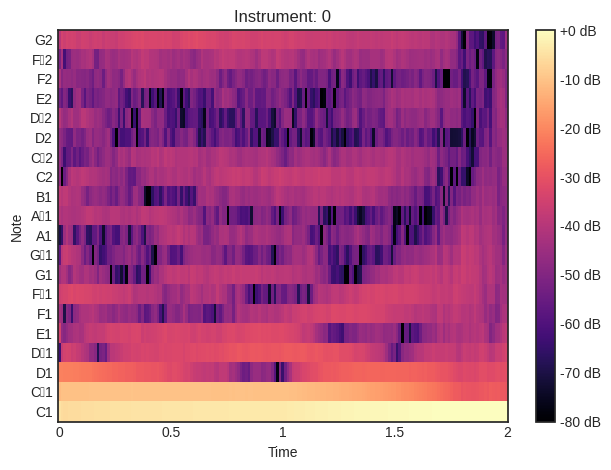

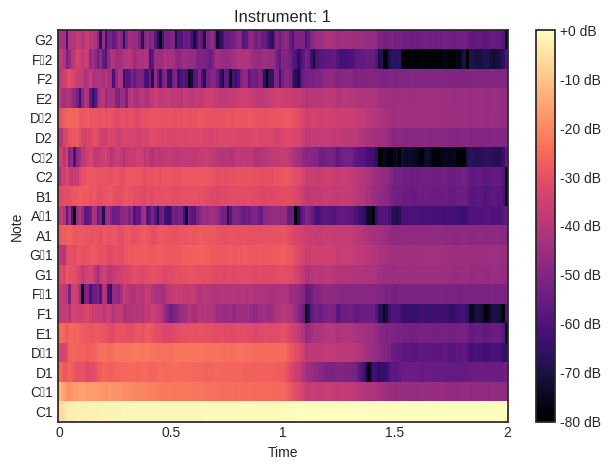

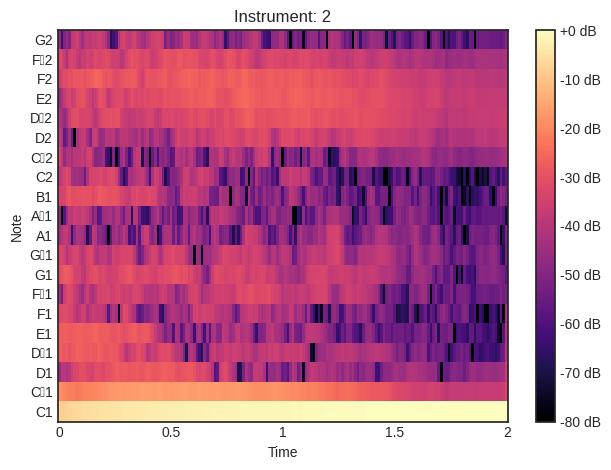

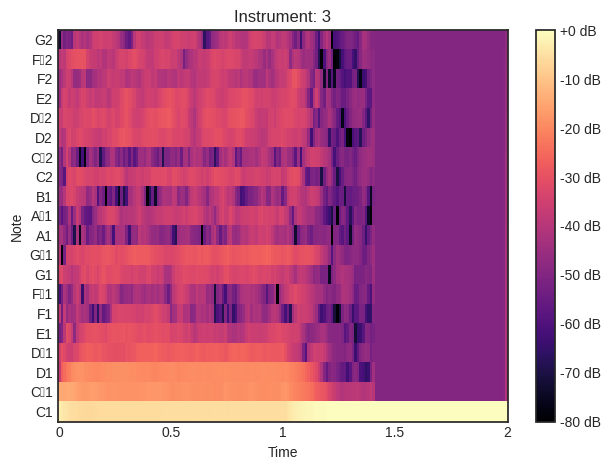

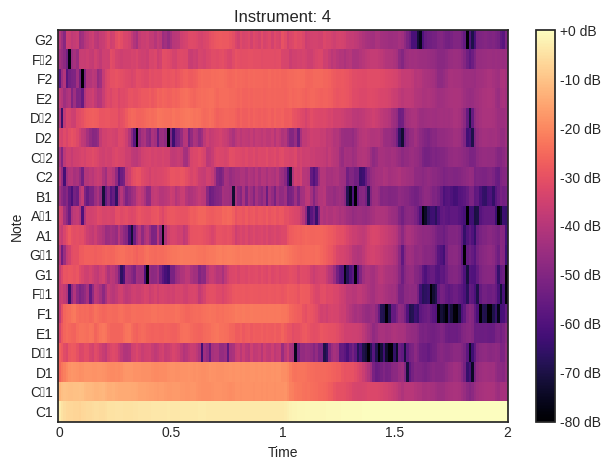

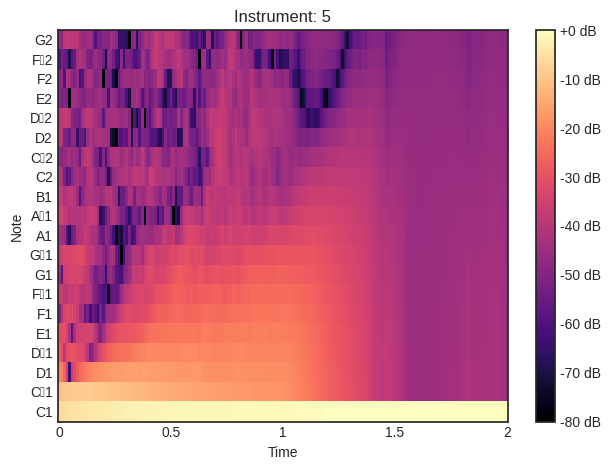

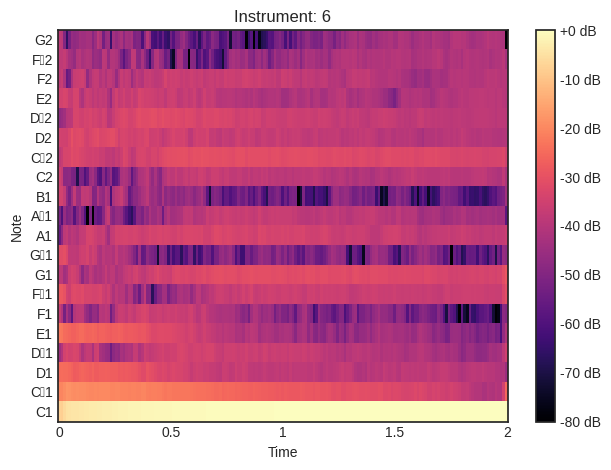

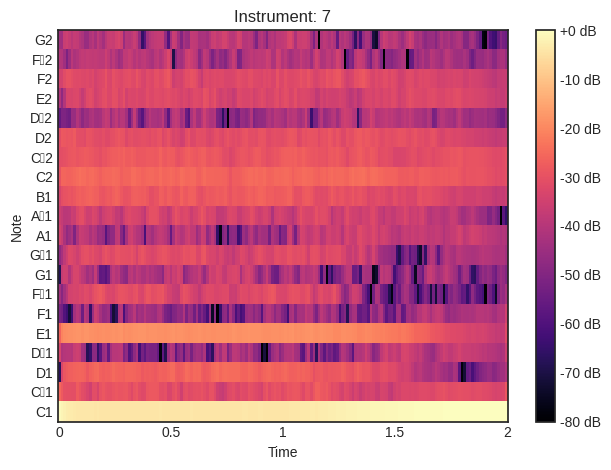

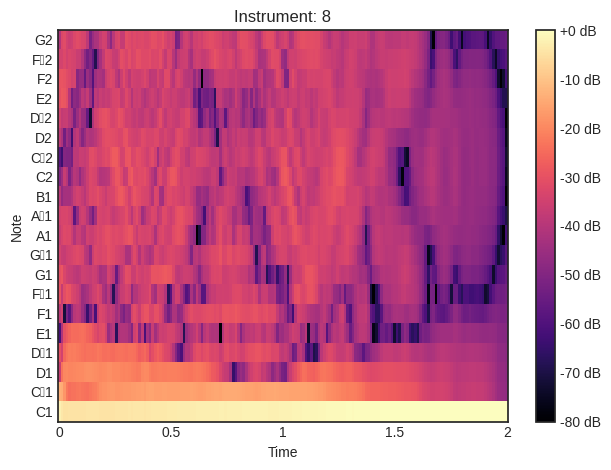

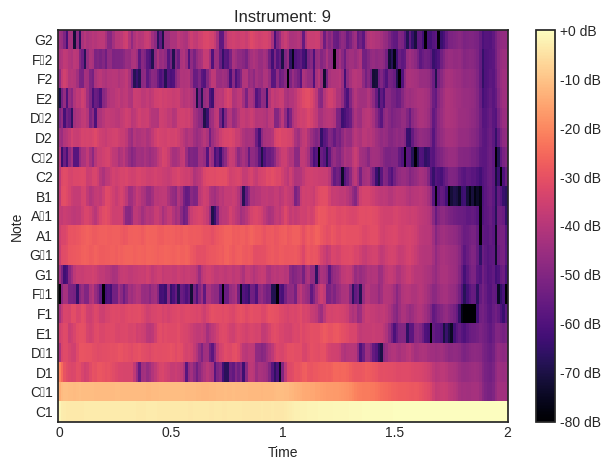

In [46]:
for i in range(0, len(instruments) * num_notes, num_notes):
  amp_db = librosa.amplitude_to_db(np.abs(audio_mfcc[i]), ref=np.max)
  librosa.display.specshow(amp_db, sr=sr, x_axis='time', y_axis='cqt_note')
  plt.colorbar(format='%+2.0f dB')
  plt.title(f'Instrument: {inst[i]}')
  plt.tight_layout()
  plt.show()


In [47]:
mfcc_np = np.array(audio_mfcc, np.float32)
inst_np = np.array(inst, np.int16)

print(mfcc_np.shape,inst_np.shape)

(500, 20, 173) (500,)




*   분류기에서 사용하기 위해 3차원 벡터를 2차원 벡터로 변환



In [48]:
mfcc_np = mfcc_np.reshape((500,20 * 173))
print(mfcc_np.shape)

(500, 3460)




*   읽어온 데이터는 음량이나 범위가 다를 수 있음
*   min-max scaling을 통해 데이터의 범위를 조정함



In [49]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(mfcc_np)

MinMaxScaler()

* 학습 데이터와 실험 데이터를 분리

In [50]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(mfcc_np, inst_np, test_size=0.2)

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(400, 3460) (400,)
(100, 3460) (100,)


### Logistic Regression

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

LR = LogisticRegression()
LR.fit(train_x, train_y)
pred = LR.predict(test_x)
acc = accuracy_score(pred, test_y)
print(f"정답률 : {acc * 100}%")

정답률 : 94.0%


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Support Vector Machine

In [52]:
from sklearn import svm
SVM = svm.SVC(kernel='linear')
SVM.fit(train_x, train_y)
pred = SVM.predict(test_x)
acc = accuracy_score(pred, test_y)
print(f"정답률 : {acc * 100}%")

정답률 : 95.0%


### Decision Tree

In [53]:
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier()
DT.fit(train_x, train_y)
pred = DT.predict(test_x)
acc = accuracy_score(pred, test_y)
print(f"정답률 : {acc * 100}%")

정답률 : 85.0%


## MFCC를 이용한 딥러닝 오디오 분류

* 앞선 문제점을 극복하기 위해 오디오 데이터에 특화된 분류 방법 필요
* 오디오 데이터를 spectrogram으로 가공하면 파장과 세기를 가진 이미지(2차원 배열)가 생성
* 이 spectrogram을 CNN 이미지 분류를 통해 각 악기 소리를 분류

### DNN 모델 구성

In [54]:
from keras.utils import to_categorical

mfcc_np = np.array(audio_mfcc, np.float32)
mfcc_np = mfcc_np.reshape((500,20 * 173))
mfcc_array = np.expand_dims(cqt_np, -1)
inst_cat = to_categorical(inst_np)

train_x, test_x, train_y, test_y = train_test_split(mfcc_array, inst_cat, test_size=0.2)

print(train_x.shape, test_x.shape)
print(train_y.shape, test_y.shape)

(400, 168, 87, 1) (100, 168, 87, 1)
(400, 10) (100, 10)


In [55]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense

def model_build():
  model = Sequential()
  input = Input(shape = (3460,), name='input')
  output = Dense(512, activation='relu', name='hidden1')(input)
  output = Dense(256, activation='relu', name='hidden2')(output)
  output = Dense(128, activation='relu', name='hidden3')(output)
  output = Dense(10, activation='softmax', name='output')(output)

  model = Model(inputs=[input], outputs=output)
  model.compile(loss='categorical_crossentropy', metrics=['acc'])
  return model

In [75]:
model = model_build()
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 20, 173, 1)]      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 20, 173, 128)      1280      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 10, 87, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 10, 87, 256)       295168    
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 5, 44, 256)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 5, 44, 512)        1180

In [76]:
history = model.fit(train_x, train_y, epochs=30, batch_size=128, validation_split=0.2)

Epoch 1/30
3/3 [==============================] - 2s 197ms/step - loss: 81.9675 - acc: 0.0938 - val_loss: 60.9654 - val_acc: 0.1375
Epoch 2/30
3/3 [==============================] - 0s 86ms/step - loss: 37.9126 - acc: 0.1000 - val_loss: 5.4309 - val_acc: 0.1125
Epoch 3/30
3/3 [==============================] - 0s 80ms/step - loss: 4.1174 - acc: 0.1594 - val_loss: 2.3346 - val_acc: 0.0750
Epoch 4/30
3/3 [==============================] - 0s 80ms/step - loss: 2.3070 - acc: 0.1531 - val_loss: 2.2124 - val_acc: 0.1750
Epoch 5/30
3/3 [==============================] - 0s 81ms/step - loss: 2.1630 - acc: 0.2156 - val_loss: 1.9657 - val_acc: 0.4625
Epoch 6/30
3/3 [==============================] - 0s 82ms/step - loss: 1.9033 - acc: 0.4375 - val_loss: 1.7340 - val_acc: 0.3250
Epoch 7/30
3/3 [==============================] - 0s 89ms/step - loss: 1.5361 - acc: 0.4969 - val_loss: 1.3102 - val_acc: 0.5625
Epoch 8/30
3/3 [==============================] - 0s 101ms/step - loss: 1.2063 - acc: 0.5875 

In [77]:
def plot_history(history_dict):
  loss = history_dict['loss']

  val_loss = history_dict['val_loss']

  epochs = range(1, len(loss) + 1 )
  fig = plt.figure(figsize=(14,5))

  ax1 = fig.add_subplot(1,2,1)
  ax1.plot(epochs, loss, 'b--', label='train_loss')
  ax1.plot(epochs, val_loss, 'r:', label='val_loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.grid()
  ax1.legend()


  acc = history_dict['acc']
  val_acc = history_dict['val_acc']

  ax2 = fig.add_subplot(1,2,2)
  ax2.plot(epochs, acc, 'b--', label='train_accuracy')
  ax2.plot(epochs, val_acc, 'r:', label='val_accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Loss')
  ax2.grid()
  ax2.legend()

  plt.show()

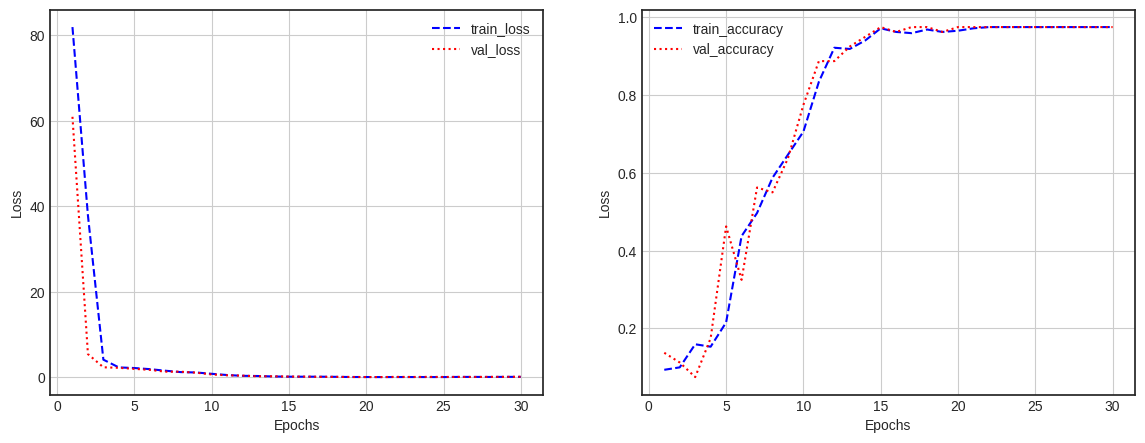

In [78]:
plot_history(history.history)

In [82]:
result = model.evaluate(test_x,test_y)

print(f"손실   : {result[0] * 100}%")
print(f"정확도 : {result[1] * 100}%")

4/4 [==============================] - 0s 11ms/step - loss: 0.0532 - acc: 0.9900
손실   : 5.315086245536804%
정확도 : 99.00000095367432%


### CNN 모델 구성

In [83]:
from keras.utils import to_categorical

mfcc_np = np.array(audio_mfcc, np.float32)
mfcc_array = np.expand_dims(mfcc_np, -1)
inst_cat = to_categorical(inst_np)

train_x, test_x, train_y, test_y = train_test_split(mfcc_array, inst_cat, test_size=0.2)

print(train_x.shape, test_x.shape)
print(train_y.shape, test_y.shape)

(400, 20, 173, 1) (100, 20, 173, 1)
(400, 10) (100, 10)




*   spectrogram을 분류할 CNN 모델 구성
*   모델의 구성은 여타 이미지 분류 모델과 다르지 않음
*   spectrogram은 1차원 이미지로 간주


In [84]:
from keras.layers import Conv2D, MaxPool2D, Flatten, Input, Dense
from keras.models import Sequential, Model
def model_build():
  model = Sequential()

  input = Input(shape = (20,173,1))

  output = Conv2D(128, 3, strides=1, padding='same', activation='relu')(input)
  output = MaxPool2D(pool_size=(2,2), strides=2, padding='same' )(output)

  output = Conv2D(256, 3, strides=1, padding='same', activation='relu')(output)
  output = MaxPool2D(pool_size=(2,2), strides=2, padding='same' )(output)

  output = Conv2D(512, 3, strides=1, padding='same', activation='relu')(output)
  output = MaxPool2D(pool_size=(2,2), strides=2, padding='same' )(output)

  output = Flatten()(output)
  output = Dense(512, activation='relu')(output)
  output = Dense(256, activation='relu')(output)
  output = Dense(128, activation='relu')(output)
  output = Dense(10, activation='softmax')(output)

  model = Model(inputs=[input], outputs=output)

  model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['acc']
  )
  return model


In [85]:
model = model_build()
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 20, 173, 1)]      0         
                                                                 
 conv2d_12 (Conv2D)          (None, 20, 173, 128)      1280      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 10, 87, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 10, 87, 256)       295168    
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 5, 44, 256)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 5, 44, 512)        1180

In [86]:
history = model.fit(train_x, train_y, epochs=30, batch_size=128, validation_split=0.2)

Epoch 1/30
3/3 [==============================] - 3s 194ms/step - loss: 101.1324 - acc: 0.1187 - val_loss: 34.3032 - val_acc: 0.1000
Epoch 2/30
3/3 [==============================] - 0s 81ms/step - loss: 22.7650 - acc: 0.0969 - val_loss: 4.7030 - val_acc: 0.0875
Epoch 3/30
3/3 [==============================] - 0s 92ms/step - loss: 3.5804 - acc: 0.1156 - val_loss: 2.4463 - val_acc: 0.1500
Epoch 4/30
3/3 [==============================] - 0s 82ms/step - loss: 2.3139 - acc: 0.2094 - val_loss: 2.2315 - val_acc: 0.2375
Epoch 5/30
3/3 [==============================] - 0s 87ms/step - loss: 2.1519 - acc: 0.2875 - val_loss: 1.9977 - val_acc: 0.2000
Epoch 6/30
3/3 [==============================] - 0s 82ms/step - loss: 1.8893 - acc: 0.3562 - val_loss: 1.7301 - val_acc: 0.4000
Epoch 7/30
3/3 [==============================] - 0s 90ms/step - loss: 1.6184 - acc: 0.4437 - val_loss: 1.4464 - val_acc: 0.4750
Epoch 8/30
3/3 [==============================] - 0s 82ms/step - loss: 1.2887 - acc: 0.5656 

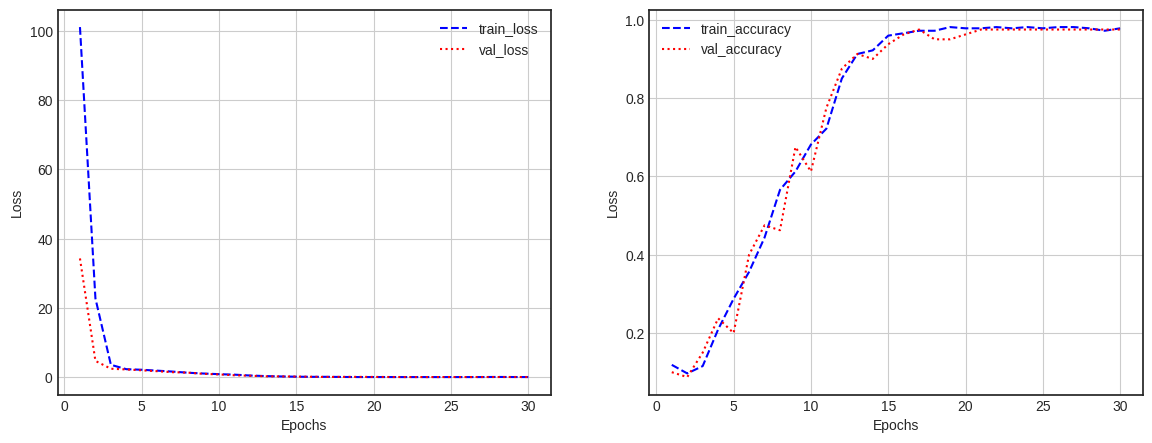

In [87]:
plot_history(history.history)



*   훈련한 모델에 대한 정확도 평가
*   앞선 일반 분류 방법보다 정확도가 많이 오른 것을 확인할 수 있음



In [88]:
result = model.evaluate(test_x,test_y)

print(f"손실   : {result[0]}")
print(f"정확도 : {result[1]}")

4/4 [==============================] - 0s 7ms/step - loss: 0.1049 - acc: 0.9700
손실   : 0.1049220934510231
정확도 : 0.9700000286102295
